<a href="https://colab.research.google.com/github/MedicalImageAnalysisTutorials/DeepLearning4All/blob/main/IA_DNN_ImageClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Setup 
doInstall =1
if doInstall:
  !pip install SimpleITK

import os, random, time, math
import numpy as np
import matplotlib.pyplot as plt
import cv2 

try:   
  import SimpleITK as sitk 
except:
  print("please install simpleitk") 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import datasets, layers, models

# to reproduce the same results given same input
np.random.seed(1)               

# Image classification using NN

First let's try a simple [Neural Network (NN)](https://towardsdatascience.com/coding-neural-network-forward-propagation-and-backpropagtion-ccf8cf369f76) with two hidden layers. It looks similar to this:  

![](https://miro.medium.com/max/2400/0*hzIQ5Fs-g8iBpVWq.jpg)

The input layer is our image sample (after converted to 1D), each pixel is represented by a neuron. The output layer contains neurons represent the classes (in our case 10 neurons) 


I will use two popular public datasets [MINST](http://yann.lecun.com/exdb/mnist/) and [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). Both have 10 classes. 


Usually number of the classes , i.e. 10 neurons, is used for the outoutput but one can used one neuron which is [not a good idea](https://stackoverflow.com/questions/45861547/neural-network-predict-mnist-digits-only-with-one-neuron-in-the-output-layer).. Digit recognition is a classification problem. By only using a single output neuron we are proposing to treat it as a regression problem. The implicit assumption we are making is that numbers that are close to each other numerically also look similar. This is obviously not the case. For instance, 3 and 5 look more similar than 3 and 4 as the bottom part is the same. Also, regression models assume that the input is ordered (one can use any order, for example 1,2,3.... or 1,3,2,5,4 or any other and the model will have different parameters). Some good ideas can be found in [Introduction to Statistical Learning free book](http://www-bcf.usc.edu/~gareth/ISL/)



## Reading and exploring the datasets



dataset shape   :  (50000, 28, 28, 1)
number of images:  50000
image size      :  (28, 28, 1)
image data type :  <class 'numpy.uint8'>
image max  value:  255
image min  value:  0
gray or binary image (not color image)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


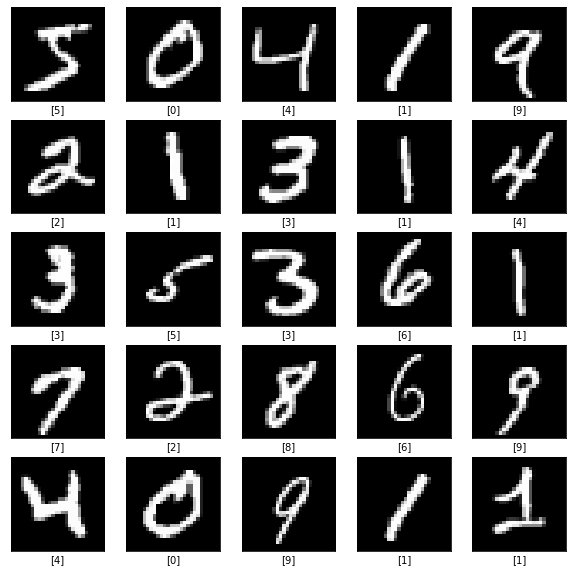

(50000, 784) (50000, 1)


In [2]:
datasetID = 1  # 1:minst is selected by default, for cifar10 use 2
NNID      = 1  # 1:NN is by default, for DNN use 2,or 3, for 3D use 4  
number_of_classes = 10  # each datasets have 10 classes
showSamples = 1
# if you have large GPU memory you can combine the images to batches 
# for faster training.
# It is good to try different values
batch_size = 2 # you can try larger batch size e.g. 1024 * 6

doAug = 0

# minst dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
class_names = range(10)
if datasetID==2:
    # cifar10 dataset
    # The CIFAR10 dataset contains 60,000 color images in 10 classes, 
    # with 6,000 images in each class.
    # The dataset is divided into 50,000 training images and 10,000 testing images.
    # The classes are mutually exclusive and there is no overlap between them.

    (x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
    if NNID==4:
        #TODO: fix this 
        showSamples =0
        
        x_train = x_train.reshape(-1,32*32*3) # (32 * 32 * 3)        
        x_train = np.resize(x_train,(x_train.shape[0],15,15,15))        
        x_train = x_train.reshape(-1,15,15,15)
        x_test = x_test.reshape(-1,32*32*3) # (32 * 32 * 3)
        x_test = np.resize(x_test,(x_test.shape[0],15,15,15))
        x_test = x_test.reshape(-1,15,15,15)
        x_train  =  x_train[..., np.newaxis] # np.reshape(x_train, (-1, h,w,1))
        y_train  =  y_train[..., np.newaxis] # np.reshape(y_train, (-1, h,w,1))
        x_test   =  x_test[..., np.newaxis]  # np.reshape(x_test,  (-1, h,w,1))
        y_test   =  y_test[..., np.newaxis]  # np.reshape(y_test,  (-1, h,w,1))


        print(x_train.shape)
        print(x_test.shape)


# get size 
h = x_train.shape[1] # image height
w = x_train.shape[2] # image width
# check for rgb 
try:
    # number of channels
    c =  x_train.shape[3]
except:
    # number of channels
    c =  1
    # if there is no number of channels, add 1
    x_train  =  x_train[..., np.newaxis] # np.reshape(x_train, (-1, h,w,1))
    y_train  =  y_train[..., np.newaxis] # np.reshape(y_train, (-1, h,w,1))
    x_test   =  x_test[..., np.newaxis]  # np.reshape(x_test,  (-1, h,w,1))
    y_test   =  y_test[..., np.newaxis]  # np.reshape(y_test,  (-1, h,w,1))


# Reserve 10,000 samples for validation.
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

number_of_pixels = h * w * c


print("dataset shape   : ",x_train.shape)
print("number of images: ",x_train.shape[0])
print("image size      : ",x_train[0].shape)
print("image data type : ",type(x_train[0][0][0][0]))
print("image max  value: ",np.max(x_train[0]))
print("image min  value: ",np.min(x_train[0]))
if c==1:
   print("gray or binary image (not color image)")
elif c==3:
   print("rgb color image (or probably non-color image represented with 3 channels)")


# display sample images 
if showSamples:
    plt.figure(figsize=(10,10))
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        #plt.imshow(x_train[i])
        plt.imshow(cv2.cvtColor(x_train[i], cv2.COLOR_BGR2RGB))

        # The CIFAR labels happen to be arrays, 
        # which is why you need the extra index
        if datasetID==1:
            plt.xlabel(y_train[i])
        elif datasetID==2:
            plt.xlabel(class_names[y_train[i][0]])
    plt.show()


# normalisation
x_train = np.array([ x/255.0 for x in x_train])
x_val   = np.array([ x/255.0 for x in x_val])
x_test  = np.array([ x/255.0 for x in x_test])
#y_train = y_train.astype(np.float32)

# for NN we need 1D 
if NNID ==1:
   x_train = np.reshape(x_train, (-1, number_of_pixels))
   x_val   = np.reshape(x_val,  (-1, number_of_pixels))
   x_test  = np.reshape(x_test , (-1, number_of_pixels))

# Prepare the training dataset.
print(x_train.shape,y_train.shape)
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
#train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

# Prepare the test dataset.
tst_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
tst_dataset = tst_dataset.batch(batch_size)

## Dataset augmentation

It is important to train the model on different variations of the dataset. It is also important to have large datset for training.

Using dataset augmentation helps to achieve both of the above goals. From one image, one can generate hundred thousands of images using image transformation.

The image transformation could be [spatial transform]() or point transform where we move the points of the image to new locations e.g. shifting, flipping, and/or rotating the imag. 

Another type of transformation is intensity transform or pixel transform where we change the color values of the pixels in the image e.g. invert the color, add more brightness or darkness. 



In [3]:
def imagePixelTransforms(img):    
    images = []
    # let's make 3 simple transformations
    img1   = 1.0- img # invert color
    img2   = img +0.3 # more brightness
    img3   = img -0.3 # more darkness
    images = np.array([img1,img2,img3])
    images = [ img.reshape(img.shape) for img in images]

    # plt.figure() ;    plt.imshow(img)
    # plt.figure() ;    plt.imshow(img1)
    # plt.figure() ;    plt.imshow(img2)
    # plt.figure() ;    plt.imshow(img3)    
    return images

def imagePointTransforms(img):
    images = []
    # let's make 3 simple transformations
    # Perform the rotation
    center  = (img.shape[0] / 2, img.shape[1] / 2)
    sz      = (img.shape[1], img.shape[0])
    tMatrix = cv2.getRotationMatrix2D(center, 45, 1)
    img1 = cv2.warpAffine(img, tMatrix, sz)
    img1 = img1[...,np.newaxis] if img1.shape !=img.shape else img1
    tMatrix = cv2.getRotationMatrix2D(center, 90, 1)
    img2 = cv2.warpAffine(img, tMatrix, sz)
    img2 = img2[...,np.newaxis] if img2.shape !=img.shape else img2
    tMatrix = cv2.getRotationMatrix2D(center, 270, 1)
    img3 = cv2.warpAffine(img, tMatrix, sz)
    img3 = img3[...,np.newaxis] if img3.shape !=img.shape else img3

    images = np.array([img1,img2,img3])
    # plt.figure() ;    plt.imshow(img)
    # plt.figure() ;    plt.imshow(img1)
    # plt.figure() ;    plt.imshow(img2)
    # plt.figure() ;    plt.imshow(img3)    
    #plt.figure() ;    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # plt.figure() ;    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    return images


# define a function for sitk transform
def resample(img_array, transform):
    # Output image Origin, Spacing, Size, Direction are taken from the reference
    # image in this call to Resample
    image = sitk.GetImageFromArray(img_array)
    reference_image = image
    interpolator = sitk.sitkCosineWindowedSinc
    default_value = 100.0
    resampled_img = sitk.Resample(image, reference_image, transform,
                         interpolator, default_value)
    resampled_array = sitk.GetArrayFromImage(resampled_img)
    return resampled_array

def affine_rotate(transform, degrees):
    parameters = np.array(transform.GetParameters())
    new_transform = sitk.AffineTransform(transform)
    dimension =3 
    matrix = np.array(transform.GetMatrix()).reshape((dimension,dimension))
    radians = -np.pi * degrees / 180.
    rotation = np.array([[1  ,0,0], 
                         [0, np.cos(radians), -np.sin(radians)],
                         [0, np.sin(radians), np.cos(radians)]]
                        )
    new_matrix = np.dot(rotation, matrix)
    new_transform.SetMatrix(new_matrix.ravel())
    return new_transform


def imagePoint3DTransforms(img):
    #print("imagePoint3DTransforms")
    images = []
    # let's make 3 simple transformations
    # Perform the rotation
    # In SimpleITK resampling convention, the transformation maps points 
    # from the fixed image to the moving image,
    # so inverse of the transform is applied

    center = (img.shape[0] /2, img.shape[1] /2,img.shape[1] /2)
    rotation_around_center = sitk.AffineTransform(3)
    rotation_around_center.SetCenter(center)
    
    rotation_around_center = affine_rotate(rotation_around_center, -45)
    img1 = resample(img, rotation_around_center)

    rotation_around_center = affine_rotate(rotation_around_center, -90)
    img2 = resample(img, rotation_around_center)

    rotation_around_center = affine_rotate(rotation_around_center, -90)
    img3 = resample(img, rotation_around_center)

    images = np.array([img1,img2,img3])
    # plt.figure() ;    plt.imshow(img)
    # plt.figure() ;    plt.imshow(img1)
    # plt.figure() ;    plt.imshow(img2)
    # plt.figure() ;    plt.imshow(img3)    
    #plt.figure() ;    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # plt.figure() ;    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
    return images

def doAugmentation(images,labels,batch_size):
    # input is an image or a batch e.g. list of images 
    # get numpy arrays from the tensor    
    images = images.numpy()
    labels = labels.numpy()
    # if 1d convert back to 2d
    #print(images.shape)
    rgb = 0 ; is3d = 0
    if len(images.shape) == 2:
       try: 
          img2d_shape = int(math.sqrt(images.shape[1])) # gray or binary image
          images =images.reshape(-1,img2d_shape,img2d_shape)
       except:
          try: 
            img2d_shape = int(math.sqrt(images.shape[1]/3)) # rgb image
            images =images.reshape(-1,img2d_shape,img2d_shape,3)
            rgb = 1  
          except:
            pass  
            # img3d_shape = int(math.sqrt(images.shape[1]/3)) # rgb image
            # images =images.reshape(-1,img2d_shape,img2d_shape,3)
            # is3d = 1  



    x_outputs = [] ; y_outputs = []
    i = 0
    for img in images:
        #print("-------------------------", i ,"--------------------")
        if NNID==4:
           img = img.squeeze() 
        # from each images we generate 6 images
        # 64 batch will generate 448
        x_outputs.extend([img])
        imgs1 = imagePoint3DTransforms(img)
        imgs2 = imagePixelTransforms(img)
        #if not rgb:
           #imgs1 = np.array( x[...,np.newaxis] for x in imgs1 if len(x.shape)<3) 
           #imgs2 = np.array( x[...,np.newaxis] for x in imgs2 if len(x.shape)<3)
        x_outputs.extend(imgs1) # 3 images
        x_outputs.extend(imgs2) # 3 images
        # print(img.shape)
        # print(imgs1[0].shape)
        # print(imgs2[0].shape)
        # assign the same label to all transformed images
        for j in range ( len(imgs1) +len(imgs2)+1):
            y_outputs.extend([labels[i]])

        i = i +1
    x_outputs = np.array(x_outputs)
    if NNID==4:
       x_outputs = np.array([x[...,np.newaxis] for x in x_outputs])
    y_outputs = np.array(y_outputs)

    if (not rgb) and (NNID==1):
       x_outputs = np.reshape(x_outputs, (-1,img2d_shape*img2d_shape,1))
    elif (rgb) and (NNID==1):
       x_outputs = np.reshape(x_outputs, (-1,img2d_shape*img2d_shape*3))   

    new_train_dataset = tf.data.Dataset.from_tensor_slices((x_outputs, y_outputs))
    new_train_dataset = new_train_dataset.shuffle(buffer_size=1024).batch(batch_size)

    return new_train_dataset

## Creating NN model



In [4]:
# Tensorflow  ------------------
#https://www.tensorflow.org/guide/keras/custom_layers_and_models
class IALinear(keras.layers.Layer):
    def __init__(self):
        super(IALinear, self).__init__()

    # initialise weights with unknown shape    
    def build(self, input_shape):
        # initialize the weights randomly
        self.w = tf.Variable(
            initial_value=tf.random_normal_initializer(
                           shape=(input_shape, input_shape), dtype="float32"),
                           # non trainable are not use in backpropagation
                           trainable=True,   ) 
        # initialize the bias with zeros
        self.b = tf.Variable(
            initial_value=tf.zeros_initializer(
                   shape=(input_shape,), dtype="float32"), trainable=True)

    # forward call:   output =  X*W + b 
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    # backward ?


# NN TensorFlow
def get_NNModel(number_of_pixels,number_of_classes):
    inputs = keras.Input(shape=(number_of_pixels,), name="digits")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(64, activation="relu", name="dense_2")(x)
    #outputs = layers.Dense(number_of_classes, name="predictions")(x)
    outputs = layers.Dense(number_of_classes, name="predictions")(x) # try with one class
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# NN TensorFlow Detailed
def getNNModel(number_of_pixels,number_of_classes):
    class NN_Class(keras.layers.Layer):
        def __init__(self):
            super(NN_Class, self).__init__()
            self.number_of_pixels  = number_of_pixels
            self.number_of_classes = number_of_classes
            #self.number_of_classes = number_of_classes
        #def build(self, number_of_pixels ):
            self.inputs  = keras.Input(shape=(self.number_of_pixels,), name="digits")
            self.dense_1 = layers.Dense(64, activation="relu", name="dense_1")
            self.dense_2 = layers.Dense(64, activation="relu", name="dense_2")
            self.outputs = layers.Dense(self.number_of_classes, name="predictions")

        def call(self, inputs):                
            x       = self.inputs(inputs)
            x       = self.dense_1(x)
            outputs = self.dense_2(x)
            return outputs
    model =  NN_Class()
    return model

    
print("NN model is defined ...")

NN model is defined ...


In [5]:
# TODO
# NN pytorch


## Define optimiser and loss function for NN and CNN

In [6]:
# Instantiate an optimizer to train the model.

optimiserID = 1 # SGD by default for ADAM use 2 
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
if optimiserID ==2:
   optimizer = keras.optimizers.Adam()#learning_rate=0.0001

# Instantiate a loss function.
lossFunctionID = 1 # SparseCategoricalCrossentropy by default for MSE use 2 
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Prepare the metrics.
train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
val_acc_metric = keras.metrics.SparseCategoricalAccuracy()
tst_acc_metric = keras.metrics.SparseCategoricalAccuracy()

if lossFunctionID==2:
   loss_fn = keras.losses.MeanSquaredError()
   # Prepare the metrics.
   train_acc_metric = keras.metrics.MeanSquaredError()
   val_acc_metric   = keras.metrics.MeanSquaredError()
   tst_acc_metric   = keras.metrics.MeanSquaredError()

elif  lossFunctionID==3:
   loss_fn = keras.losses.CategoricalCrossentropy()
   # Prepare the metrics.
   train_acc_metric = keras.metrics.CategoricalCrossentropy()
   val_acc_metric   = keras.metrics.CategoricalCrossentropy()
   tst_acc_metric   = keras.metrics.CategoricalCrossentropy()

print("optimiser, loss, and metrics are defined .... ")

optimiser, loss, and metrics are defined .... 


In [7]:
# TODO
# Pytorch



## Define training functions


In [8]:

# define training parameters and file paths 

# model log files path
modelPath   = "./modelClassification.h5"
logFilePath = "./training_log.csv"
figPath     = "./training_log.png"

logFile = open(logFilePath,'w')
logFile.write("epoch \t trnLoss \t valLoss \t trnAcc \t valAcc \t time \n" )
logFile.close()
# Using optimised tensorflow functions provides more speed

@tf.function
def train_step(model,x, y):
    with tf.GradientTape() as tape:
        #print("get result")
        logits = model(x, training=True)
        #print("get training loss value ")
        #y = keras.utils.to_categorical(y)
        #logits = (number_of_classes-1.0) * tf.sigmoid(logits)
        #print(logits,y)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

@tf.function
def val_step(model,x, y):
    val_logits = model(x, training=False)
    #y = keras.utils.to_categorical(y)
    #val_logits = (number_of_classes-1.0) * tf.sigmoid(val_logits)
    loss_value = loss_fn(y, val_logits)
    val_acc_metric.update_state(y, val_logits)
    return loss_value

# plotting function to monitor the curves
def iaPlotLoss(logPath,figPath=None):
    f = open(logPath,'r')
    lst = f.readlines()
    # first line is labels:
    labels = lst[0].split()[1:-2]
    x  = [ int(  ln.split()[0]) for ln in lst[1:]] # epoch
    y1 = [ float(ln.split()[1]) for ln in lst[1:]] # lossTrain
    y2 = [ float(ln.split()[2]) for ln in lst[1:]] # lossValidation
    y3 = [ float(ln.split()[3]) for ln in lst[1:]] # accTrain
    y4 = [ float(ln.split()[4]) for ln in lst[1:]] # accValidation
    #plotting    
    plt.clf()
    fig, ax = plt.subplots()    
    l1, = ax.plot(x, y1) ;     l2, = ax.plot(x, y2) ;
    l3, = ax.plot(x, y3) ;     l4, = ax.plot(x, y4) ;
    ax.legend((l1, l2,l3,l4), labels, loc='upper right', shadow=True)
    plt.xlabel('epoch')
    if figPath:
        plt.savefig(figPath, bbox_inches='tight')
    else:
        plt.show()
        plt.close()



## Training NN model

In [9]:
epochs = 50 # number of iterations 


if NNID==1:
    model = getNNModel(number_of_pixels,number_of_classes)
    print("===================================================")
    print("               Training Loop           ")
    print("===================================================")

    total_time_start = time.time()
    # we loop number of iterations
    # for each iteration, we loop through all the training samples
    for epoch in range(epochs):
        #print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()

        #TODO:
        # replace this part
        
        # Iterate over the batches of the dataset.
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            #print(train_dataset.shape)
            #print(x_batch_train.shape,y_batch_train.shape)
            if doAug: 
                #do augmentation
                new_train_batch = doAugmentation(x_batch_train , y_batch_train , batch_size)
                for stp, (new_x_batch_train, new_y_batch_train) in enumerate(new_train_batch):
                    #print(new_train_batch.shape)
                    #print(new_x_batch_train.shape,new_y_batch_train.shape)
                    #model.summary()
                    loss_value = train_step(model,new_x_batch_train, new_y_batch_train)
                    train_acc = train_acc_metric.result()
                    train_acc_metric.reset_states()
            else:                    
                loss_value = train_step(model,x_batch_train, y_batch_train)                    
                train_acc = train_acc_metric.result()
                train_acc_metric.reset_states()

        # Run a validation loop at the end of each epoch.
        for x_batch_val, y_batch_val in val_dataset:
            val_loss_value = val_step(model,x_batch_val, y_batch_val)

        val_acc = val_acc_metric.result()
        val_acc_metric.reset_states()
        
        # compute time required for each epoch
        end_time = time.time() - start_time

        print("epoch:%d \t trnLoss: %.4f \t valLoss: %.4f \t trnAcc: %.4f \t valAcc: %.4f \t time:  %.2f" % (epoch, float(loss_value),float(val_loss_value), float(train_acc), float(val_acc), end_time))
        logFile = open(logFilePath,'a')
        logFile.write("%d \t %.4f \t  %.4f \t %.4f \t  %.4f \t  %.2f \n" % (epoch, float(loss_value),float(val_loss_value), float(train_acc), float(val_acc), end_time))
        logFile.close()
        # plot the result
        if epoch % 10 ==0:
           # plot the result        
           iaPlotLoss(logFilePath)

    # save the final model
    model.save(modelPath)     

    # plot the result        
    iaPlotLoss(logFilePath)
    total_time_end = time.time() - total_time_start
    print("Training this dataset took ", total_time_end," seconds!") 
    print("Training this dataset took ", total_time_end/60.0," minutes!")   

               Training Loop           


TypeError: ignored

In [ ]:
##TODO pytorch

## Evaluation

In [ ]:
if NNID==1:
    # Load the saved model 
    model = keras.models.load_model(modelPath, compile=False)

    start_time = time.time() 
    # Run a validation loop at the end of each epoch.
    for x_batch_tst, y_batch_tst in tst_dataset:
        output = model.predict(x_batch_tst)
        #y = keras.utils.to_categorical(y_batch_tst)
        tst_acc_metric.update_state(y_batch_tst, output)

    tst_acc = tst_acc_metric.result()

    # compute time required for each epoch
    end_time = time.time() - start_time

    print("test accuracy : %.4f \t time:  %.2f" % (  float(tst_acc), end_time))

In [ ]:
# TODO Pytorch


# Image classification using CNN


## Creating CNN model

In [ ]:
# Simple DNN
# just two conolution layers followed by dense layer
def getSimpleDNNModel(input_shape,number_of_pixels,number_of_classes):
    nF        = 16 # number of filters
    inputs = keras.Input(shape=input_shape, name="images") 
    # Create CNN model
    x11  = layers.Conv2D(nF, (3, 3), activation='relu', input_shape=input_shape) (inputs)
    x13  = layers.MaxPooling2D((2, 2)) (x11)
    x21  = layers.Conv2D(2*nF, (3, 3), activation='relu') (x13)
    x23  = layers.MaxPooling2D((2, 2))(x21)
    #dense layer for classification
    x31 = layers.Flatten()(x23)# convert from 3d to 1d
    outputs = layers.Dense(number_of_classes, name="predictions")(x31)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

# this is a better model for CIFAR10
def getDNNModel(input_shape,number_of_pixels,number_of_classes):
    nF        = 64 # number of filters
    inputs = keras.Input(shape=input_shape, name="images") 
    # Create CNN model
    x11  = layers.Conv2D(nF, (3, 3), activation='relu', input_shape=input_shape) (inputs)
    x12  = layers.BatchNormalization()(x11)
    x13  = layers.MaxPooling2D((2, 2)) (x12)
    x14  = layers.Dropout(0.25)(x13)
    x21  = layers.Conv2D(2*nF, (3, 3), activation='relu') (x14)
    x22  = layers.BatchNormalization()(x21)
    x23  = layers.MaxPooling2D((2, 2))(x22)
    x24  = layers.Dropout(0.25)(x23)
    x31  = layers.Conv2D(2*nF, (3, 3), activation='relu')(x24)
    #dense layer for classification
    x41 = layers.Flatten()(x31)# convert from 3d to 1d
    #x7 = layers.Dense(2*nF, activation='relu')(x6)
    #x8 = layers.Dense(2*nF, activation='relu')(x7)
    x42  = layers.Dropout(0.50)(x41)
    outputs = layers.Dense(number_of_classes, name="predictions")(x42)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model
print("DNN model is defined ...")    

def getSimpleDNN3DModel(input_shape,number_of_pixels,number_of_classes):
    nF        = 16 # number of filters
    inputs = keras.Input(shape=input_shape, name="images") 
    # Create CNN model
    x11  = layers.Conv3D(nF, (3, 3, 3), activation='relu', input_shape=input_shape) (inputs)
    x13  = layers.MaxPooling3D((2, 2, 2)) (x11)
    x21  = layers.Conv3D(2*nF, (3, 3, 3), activation='relu') (x13)
    x23  = layers.MaxPooling3D((2, 2 ,2))(x21)
    #dense layer for classification
    x31 = layers.Flatten()(x23)# convert from 3d to 1d
    outputs = layers.Dense(number_of_classes, name="predictions")(x31)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


## Training CNN model

In [ ]:
# Same code as above 

epochs = 500 # number of iterations 

if NNID>=2:
    input_shape = [h,w,c] 

    if NNID==2:
       model = getSimpleDNNModel(input_shape, number_of_pixels,number_of_classes)
    elif NNID==3: # advanced 
       model = getDNNModel(input_shape, number_of_pixels,number_of_classes)
    elif NNID==4: # 3D 
       input_shape = [h,w,c,1] 
       model = getSimpleDNN3DModel(input_shape, number_of_pixels,number_of_classes)

    print("===================================================")
    print("               Training Loop           ")
    print("===================================================")
    total_time_start = time.time()
    # we loop number of iterations
    # for each iteration, we loop through all the training samples
    for epoch in range(epochs):
        #print("\nStart of epoch %d" % (epoch,))
        start_time = time.time()

        # Iterate over the batches of the dataset.
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            #print(train_dataset.shape)
            #print(x_batch_train.shape,y_batch_train.shape)
            if doAug: 
                #do augmentation
                new_train_batch = doAugmentation(x_batch_train , y_batch_train , batch_size)                
                for stp, (new_x_batch_train, new_y_batch_train) in enumerate(new_train_batch):
                    #print(stp)
                    #print(new_train_batch.shape)
                    #print(new_x_batch_train.shape,new_y_batch_train.shape)
                    #model.summary()
                    loss_value = train_step(model,new_x_batch_train, new_y_batch_train)
                    train_acc = train_acc_metric.result()
                    train_acc_metric.reset_states()
                    print("   epoch:%d \t stp %d trnLoss: %.4f " % (epoch, stp, float(loss_value)))
            else:                    
                loss_value = train_step(model,x_batch_train, y_batch_train)                    
                train_acc = train_acc_metric.result()
                train_acc_metric.reset_states()

        # Run a validation loop at the end of each epoch.
        for x_batch_val, y_batch_val in val_dataset:
            val_loss_value = val_step(model,x_batch_val, y_batch_val)

        val_acc = val_acc_metric.result()
        val_acc_metric.reset_states()
        
        # compute time required for each epoch
        end_time = time.time() - start_time

        print("epoch:%d \t trnLoss: %.4f \t valLoss: %.4f \t trnAcc: %.4f \t valAcc: %.4f \t time:  %.2f" % (epoch, float(loss_value),float(val_loss_value), float(train_acc), float(val_acc), end_time))
        logFile = open(logFilePath,'a')
        logFile.write("%d \t %.4f \t  %.4f \t %.4f \t  %.4f \t  %.2f \n" % (epoch, float(loss_value),float(val_loss_value), float(train_acc), float(val_acc), end_time))
        logFile.close()
        if epoch % 5 ==0:
           # plot the result        
           iaPlotLoss(logFilePath)
           model.save(modelPath)      
    # save the final model
    model.save(modelPath)     

    # plot the result        
    iaPlotLoss(logFilePath)
    total_time_end = time.time() - total_time_start
    print("Training this dataset took ", total_time_end," seconds!") 
    print("Training this dataset took ", total_time_end/60.0," minutes!") 


## Evaluation

In [ ]:
if NNID==2:
    # Load the saved model 
    model = keras.models.load_model(modelPath, compile=False)

    start_time = time.time() 
    # Run a validation loop at the end of each epoch.
    for x_batch_tst, y_batch_tst in tst_dataset:
        output = model.predict(x_batch_tst)
        #y = keras.utils.to_categorical(y_batch_tst)
        tst_acc_metric.update_state(y_batch_tst, output)

    tst_acc = tst_acc_metric.result()

    # compute time required for each epoch
    end_time = time.time() - start_time

    print("test accuracy : %.4f \t time:  %.2f" % (  float(tst_acc), end_time))

# Understanding traning curves

Training large datsets takes hours. It is good to check the [training curves](https://en.wikipedia.org/wiki/Learning_curve) and stop the training if it is a waste of time and resources. To do this one should check the training curves and identify specific problems.


In [ ]:
#TODO: show examples using the above datasets
# https://machinelearningmastery.com/diagnose-overfitting-underfitting-lstm-models/

## Model underfitting, overfitting, and good fitting:


Source for this part is taken from [here](https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/).

**Underfitting:**

* No learning: Training loss is a line or a noisy line
* Need more training: Traning loss is decreasing.

<div>
<img src="" width="500"/>
</div>

<div>
<img src="https://machinelearningmastery.com/wp-content/uploads/2019/02/Example-of-Training-Learning-Curve-Showing-An-Underfit-Model-That-Does-Not-Have-Sufficient-Capacity.png" width="500"/>
</div>

<!-- ![](https://machinelearningmastery.com/wp-content/uploads/2019/02/Example-of-Training-Learning-Curve-Showing-An-Underfit-Model-That-Does-Not-Have-Sufficient-Capacity.png) -->

<div>
<img src="https://machinelearningmastery.com/wp-content/uploads/2018/12/Example-of-Training-Learning-Curve-Showing-An-Underfit-Model-That-Requires-Further-Training.png" width="500"/>
</div>


<!-- ![](https://machinelearningmastery.com/wp-content/uploads/2018/12/Example-of-Training-Learning-Curve-Showing-An-Underfit-Model-That-Requires-Further-Training.png) -->

**Overfitting:**

* Training loss is decreasing 
* Validation loss is decreasing then increasing.

<div>
<img src="https://machinelearningmastery.com/wp-content/uploads/2018/12/Example-of-Train-and-Validation-Learning-Curves-Showing-An-Overfit-Model.png" width="500"/>
</div>

<!-- ![](https://machinelearningmastery.com/wp-content/uploads/2018/12/Example-of-Train-and-Validation-Learning-Curves-Showing-An-Overfit-Model.png) -->

**Good fitting:**

* Training loss is decreasing to a point of stability.
* Validation loss is decreasing to a point of stability and has a small gap with the training loss.


<div>
<img src="https://machinelearningmastery.com/wp-content/uploads/2018/12/Example-of-Train-and-Validation-Learning-Curves-Showing-A-Good-Fit.png" width="500"/>
</div>

<!-- ![](https://machinelearningmastery.com/wp-content/uploads/2018/12/Example-of-Train-and-Validation-Learning-Curves-Showing-A-Good-Fit.png) -->


## Bad Datasets

**Bad Training Dataset:**

* Training dataset has too few examples as compared to the validation dataset.
* Training loss is decreasing and validation loss is decreasing with a large gap.


<div>
<img src="https://machinelearningmastery.com/wp-content/uploads/2018/12/Example-of-Train-and-Validation-Learning-Curves-Showing-a-Training-Dataset-the-May-be-too-Small-Relative-to-the-Validation-Dataset.png" width="500"/>
</div>

<!-- ![](https://machinelearningmastery.com/wp-content/uploads/2018/12/Example-of-Train-and-Validation-Learning-Curves-Showing-a-Training-Dataset-the-May-be-too-Small-Relative-to-the-Validation-Dataset.png) -->


**Bad validation Dataset:**

* Training loss is decreasing and validation loss with noisy movements around the training loss.

<div>
<img src="https://machinelearningmastery.com/wp-content/uploads/2018/12/Example-of-Train-and-Validation-Learning-Curves-Showing-a-Validation-Dataset-the-May-be-too-Small-Relative-to-the-Training-Dataset.png" width="500"/>
</div>


* Validation loss is lower than the training loss (Use validation dataset for training)

<div>
<img src="https://machinelearningmastery.com/wp-content/uploads/2018/12/Example-of-Train-and-Validation-Learning-Curves-Showing-a-Validation-Dataset-that-is-Easier-to-Predict-than-the-Training-Dataset.png" width="500"/>
</div>


<!-- ![](https://machinelearningmastery.com/wp-content/uploads/2018/12/Example-of-Train-and-Validation-Learning-Curves-Showing-a-Validation-Dataset-the-May-be-too-Small-Relative-to-the-Training-Dataset.png)
![](https://machinelearningmastery.com/wp-content/uploads/2018/12/Example-of-Train-and-Validation-Learning-Curves-Showing-a-Validation-Dataset-that-is-Easier-to-Predict-than-the-Training-Dataset.png) -->


# More resources:

* 3Blue1Brown Neural Network [video tutorials](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi) 
* Deep Learning Video Lectures by Prof. Andreas Maier [Winter 20/21](https://www.youtube.com/watch?v=SCFToE1vM2U&list=PLpOGQvPCDQzvJEPFUQ3mJz72GJ95jyZTh)
* Some of the code in this notebook is taken from [here](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)
* Calculating number of parameters in [CNN](https://towardsdatascience.com/understanding-and-calculating-the-number-of-parameters-in-convolution-neural-networks-cnns-fc88790d530d)
* Some of the code in this notebook is taken from [here](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/cnn.ipynb)
* https://imerit.net/blog/top-13-machine-learning-image-classification-datasets-all-pbm/
* https://nihcc.app.box.com/v/ChestXray-NIHCC
* https://www.kaggle.com/xhlulu/recursion-cellular-image-classification-224-jpg
* https://www.tensorflow.org/datasets/catalog/patch_camelyon
